In [1]:
base_path='/kaggle/input/breast-cancer/Breast Cancer'
train_path='/kaggle/input/breast-cancer/Breast Cancer/train'
val_path='/kaggle/input/breast-cancer/Breast Cancer/val'
test_path='/kaggle/input/breast-cancer/Breast Cancer/test'

# import needed libraries 

In [2]:
from keras.layers import Input, Flatten
from skimage.io import imshow,imread
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.optimizers.experimental import AdamW
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.applications import imagenet_utils
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import layers
from tensorflow.keras.preprocessing import image_dataset_from_directory
import random
import os
import pandas as pd
from sklearn.metrics import accuracy_score, confusion_matrix
import time
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
batch_size = 32
target_size=(224, 224)
class_mode='categorical'

# image data generator 

In [4]:
def generate_dataset(path):
    print("\nTotal for trainning : ", end=" ")
    ds = image_dataset_from_directory(path + '/train',
                                      image_size=target_size,
                                          batch_size=batch_size)
    class_names = ds.class_names
    print(class_names)
    num_classes=len(ds.class_names) 


    image_data_generator = ImageDataGenerator(rescale = 1./255,
                                      fill_mode = 'nearest',
                                      samplewise_std_normalization=True,
                                      samplewise_center=True,
                                      horizontal_flip=True,
                                      vertical_flip=True,
                                      )
    test_image_data_generator = ImageDataGenerator(rescale = 1./255)

    print("\nFor Training : ", end=" ")
    train_generator = image_data_generator.flow_from_directory(train_path,
                                                      target_size=target_size,
                                                      batch_size=batch_size,
                                                      class_mode='categorical',
                                                      interpolation="nearest",
                                                      color_mode='rgb')


    print("\nFor Val : ", end=" ")
    validation_generator = image_data_generator.flow_from_directory(val_path,
                                                           target_size=target_size,
                                                           batch_size=batch_size,
                                                           class_mode='categorical',
                                                           shuffle = False,
                                                           interpolation="nearest",
                                                           color_mode='rgb')
    print("\nFor Test : ", end=" ")
    test_generator = test_image_data_generator.flow_from_directory(test_path,
                                                           target_size=target_size,
                                                           batch_size=batch_size,
                                                           class_mode='categorical',
                                                           shuffle=False,
                                                           interpolation="nearest",
                                                           color_mode='rgb')
    plt.figure(figsize=(30, 30))
    for images, labels in ds.take(1):
        for i in range(num_classes):
            ax = plt.subplot(9, 3, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title(class_names[labels[i]]) 
            plt.axis("off")

    return train_generator,validation_generator,test_generator,train_generator.image_shape,class_names,num_classes

# VGG16 Model

In [5]:
def initiate_model_VGG16(no_of_classes, image_size,fine_tune=0,dropout=0.0):
    vgg=VGG16(include_top=False,
        weights='imagenet',
        input_shape=image_size,
        classes=no_of_classes
    )

    if fine_tune > 0:
        for layer in vgg.layers[:-fine_tune]:
            layer.trainable = False
    else:
        for layer in vgg.layers:
            layer.trainable = False  

    top_model = Flatten(name="flatten")(vgg.output)
    top_model = Dense(4096, activation='relu')(top_model)
    top_model = Dense(4096, activation='relu')(top_model)
    if dropout > 0 :
        top_model = Dropout(dropout)(top_model)
        output_layer  = Dense(no_of_classes, activation='softmax')(top_model)

    model = Model(inputs=vgg.input, outputs= output_layer,name="VGG16")
    return model

In [6]:
#Applying Bilateral filter
import cv2 #image processing
import os

def bilateral_filter(image, d, sigma_color, sigma_space): #sigma_color (Controls color similarity)
                                                          #sigma_space(controls spatial proximity)

    filtered_image = cv2.bilateralFilter(image, d, sigma_color, sigma_space)
    return filtered_image

def process_images_in_folder(folder_path, output_folder, d, sigma_color, sigma_space):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    for filename in os.listdir(folder_path): #It iterates over the images in the specified folder
        if filename.endswith(('.jpg', '.jpeg', '.png')):
            image_path = os.path.join(folder_path, filename) #Constructs the full path to the current image file by joining the folder_path
            original_image = cv2.imread(image_path)

            filtered_image = bilateral_filter(original_image, d, sigma_color, sigma_space)

            output_path = os.path.join(output_folder, filename)
            cv2.imwrite(output_path, filtered_image)

diameter = 15
iterations = 50
iterations_list = range(1, iterations + 1)
sigma_color = 75
sigma_space = 75


input_folder = '/kaggle/input/processpred/breast-cancer'  # Replace with the path to your input folder
output_folder = '/kaggle/working/filteredoutput'

process_images_in_folder(input_folder, output_folder, diameter, sigma_color, sigma_space)

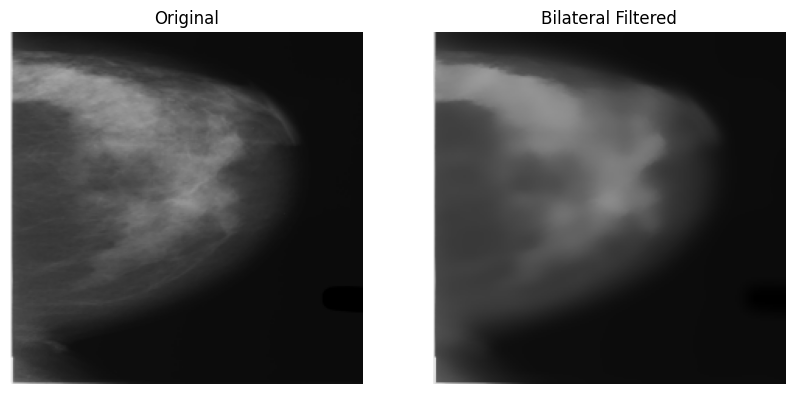

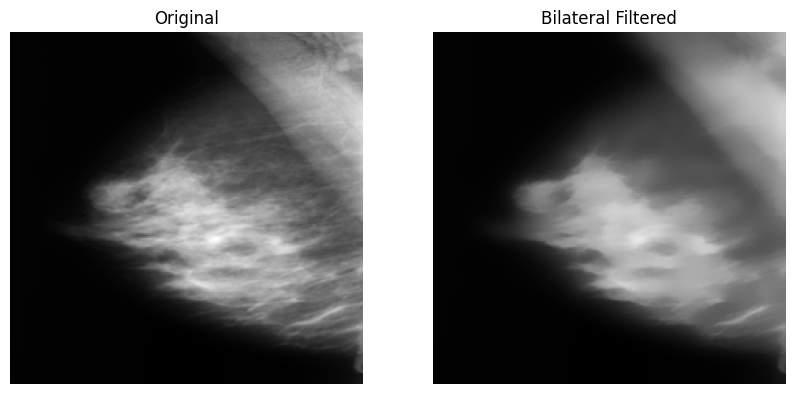

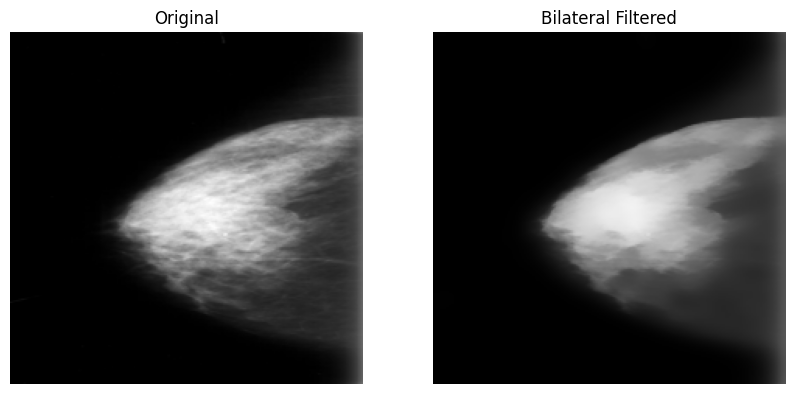

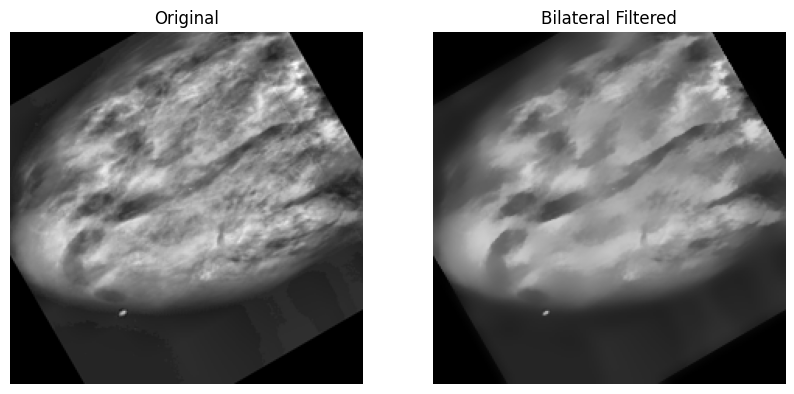

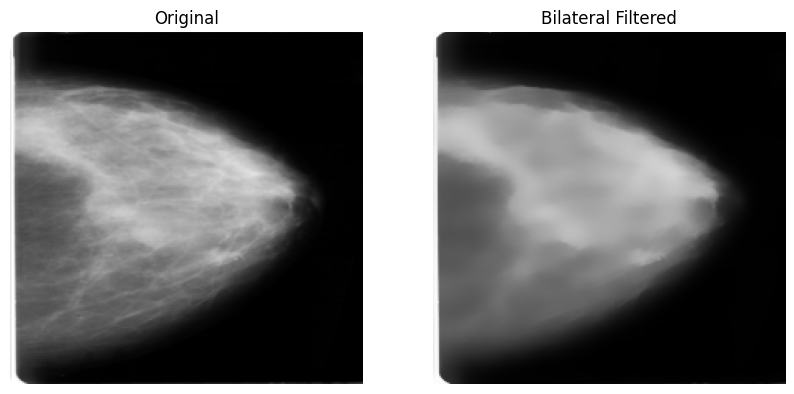

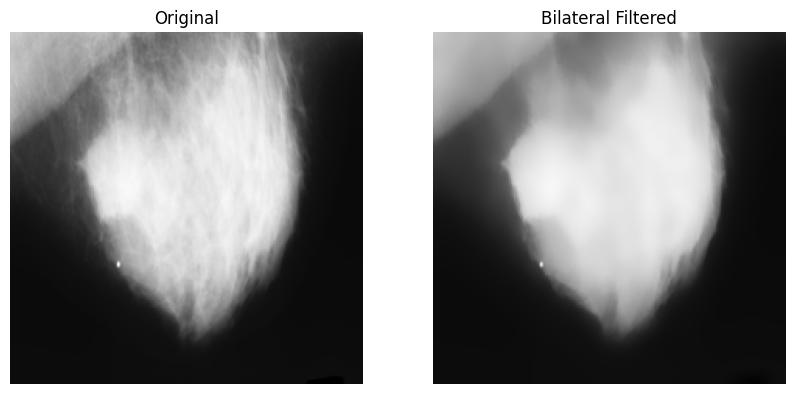

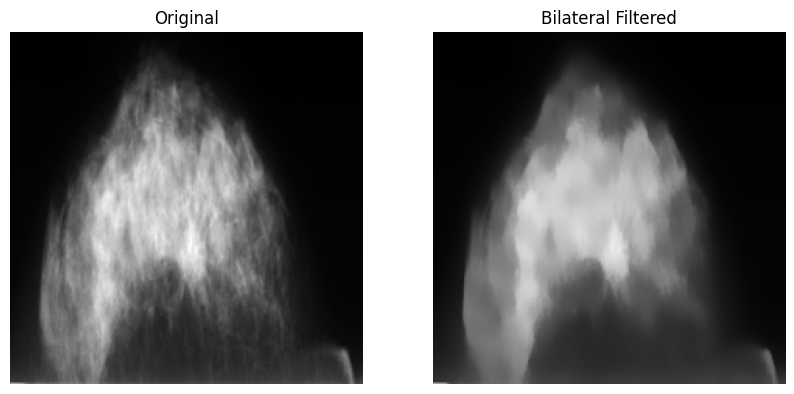

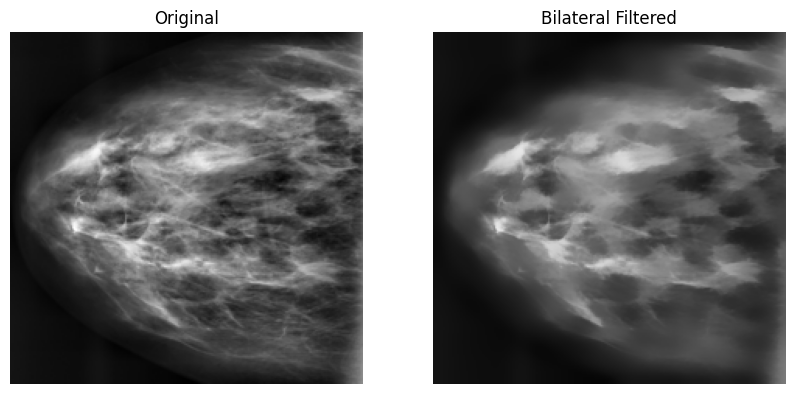

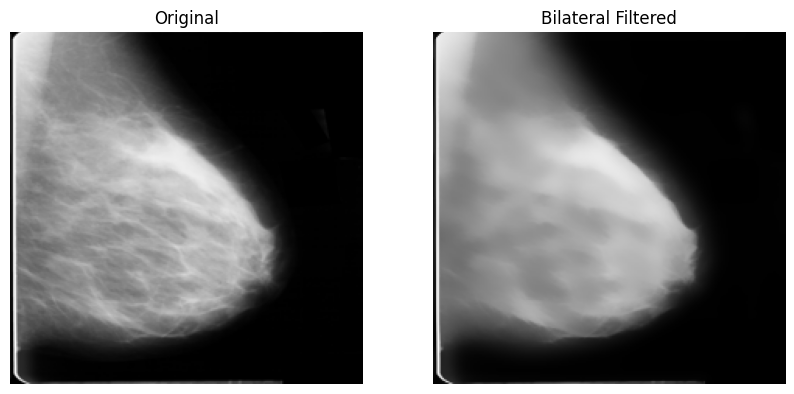

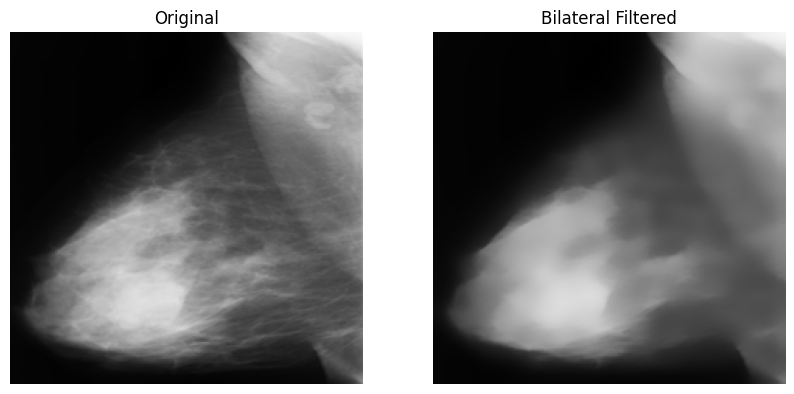

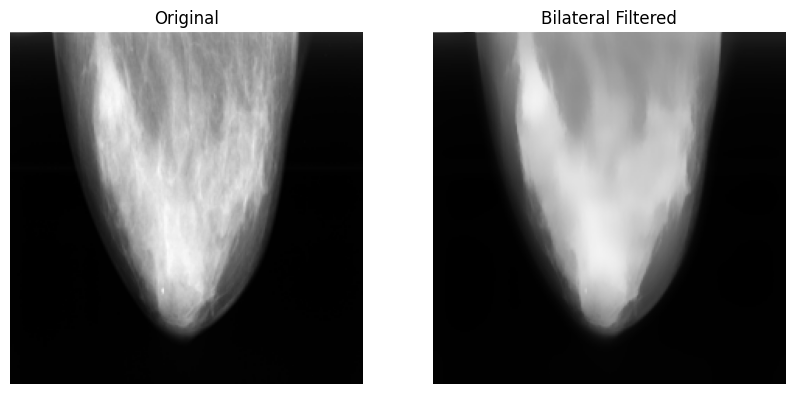

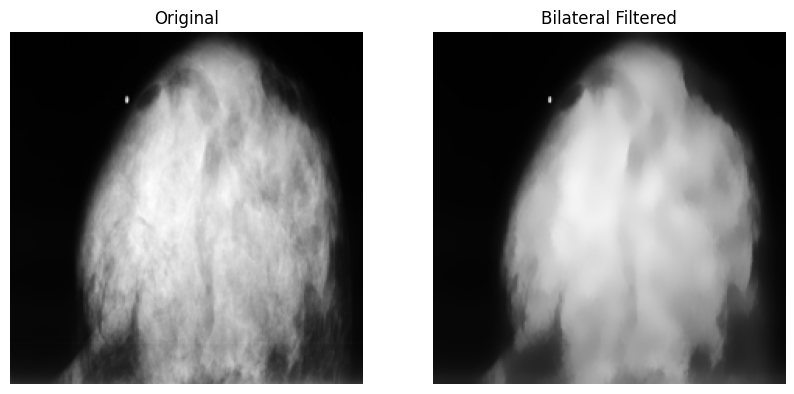

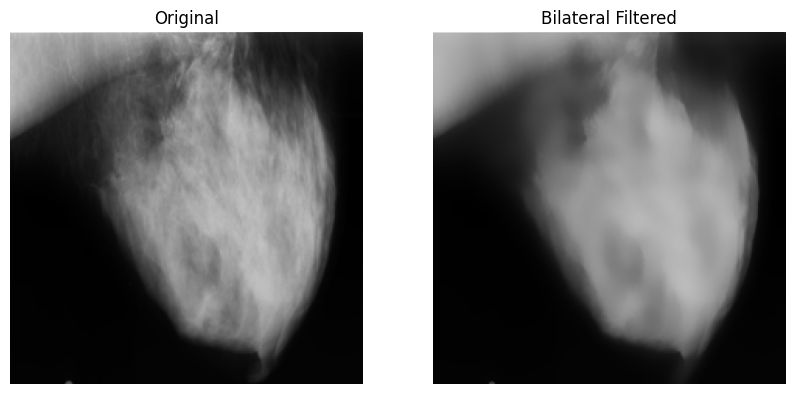

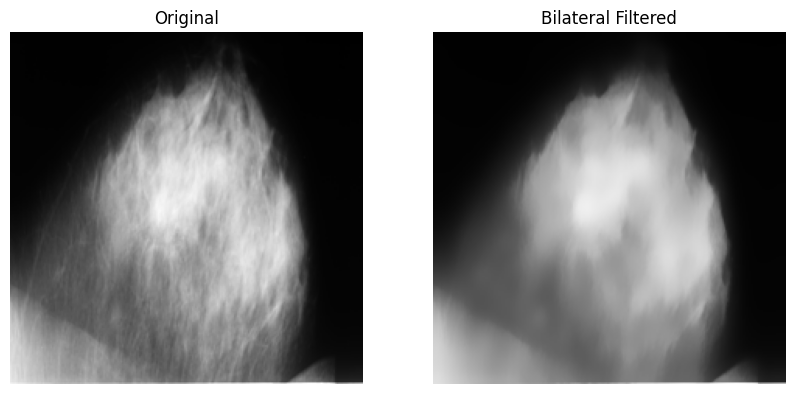

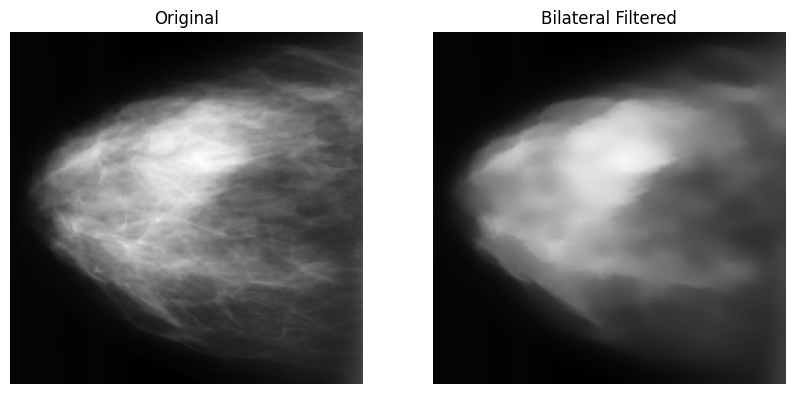

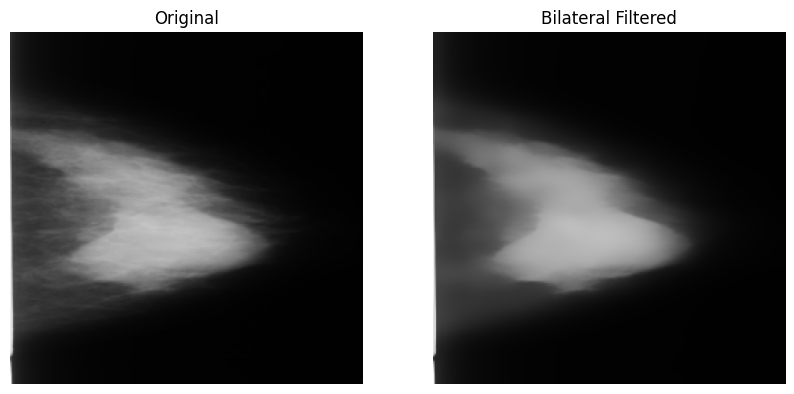

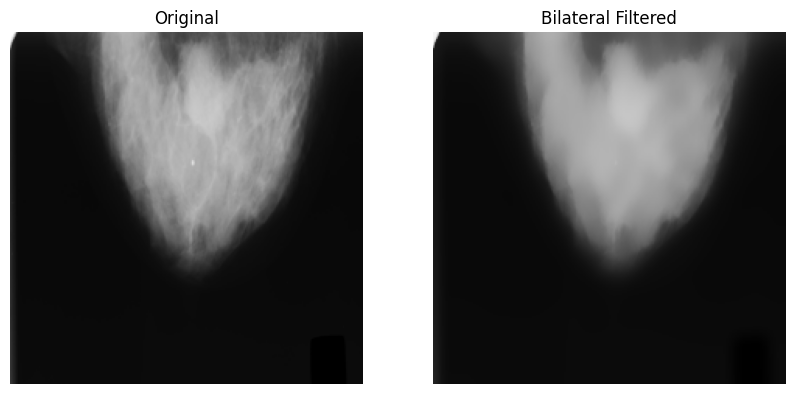

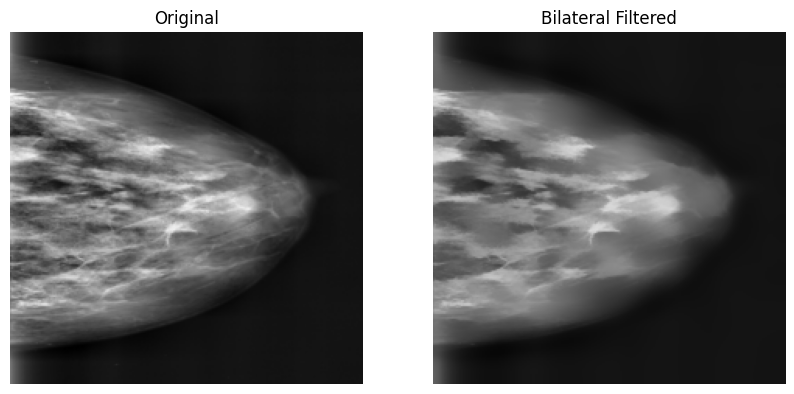

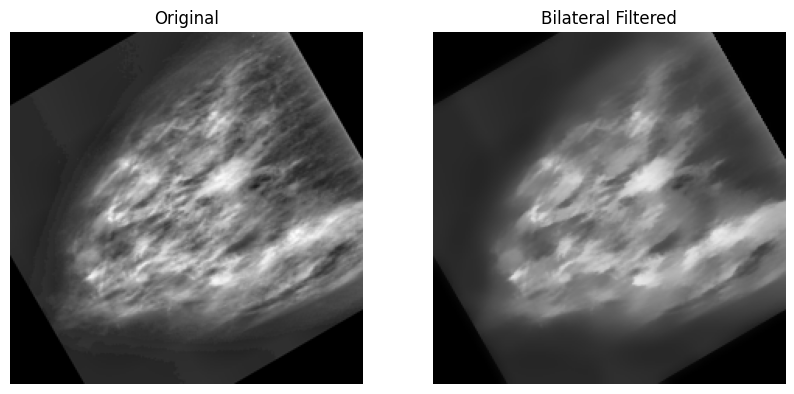

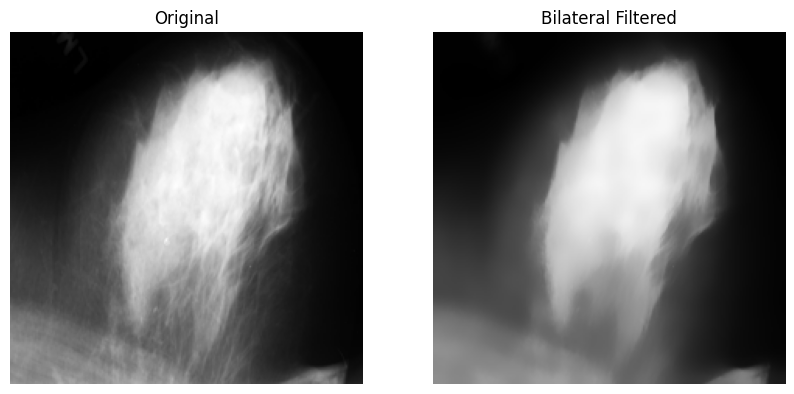

In [7]:
#Displaying original and Bilateral filtered images
import os
import cv2
import matplotlib.pyplot as plt

def bilateral_filter(image, d, sigma_color, sigma_space):
    filtered_image = cv2.bilateralFilter(image, d, sigma_color, sigma_space)
    return filtered_image

def display_images(original_image, filtered_image, title_original="Original Image", title_filtered="Filtered Image"):
    plt.figure(figsize=(10, 5))

    # Display original image
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))
    plt.title(title_original)
    plt.axis('off')

    # Display filtered image
    plt.subplot(1, 2, 2)
    plt.imshow(cv2.cvtColor(filtered_image, cv2.COLOR_BGR2RGB))
    plt.title(title_filtered)
    plt.axis('off')
    plt.show()

def process_and_display_images(input_folder, d, sigma_color, sigma_space):
    for filename in os.listdir(input_folder):  #It iterates over the images in the specified folder
        if filename.endswith(('.jpg', '.jpeg', '.png')):
            image_path = os.path.join(input_folder, filename)#Constructs the full path to the current image file by joining the folder_path
            original_image = cv2.imread(image_path)

            # Apply bilateral filter
            filtered_image = bilateral_filter(original_image, d, sigma_color, sigma_space)

            # Display original and filtered images
            display_images(original_image, filtered_image, title_original="Original", title_filtered="Bilateral Filtered")
# Example usage

diameter = 15
sigma_color = 75
sigma_space = 75

input_folder = '/kaggle/input/processpred/breast-cancer'
process_and_display_images(input_folder, diameter, sigma_color, sigma_space)

In [8]:
#ROI images extraction
import cv2
import os

def bilateral_filter(image, d, sigma_color, sigma_space):
    filtered_image = cv2.bilateralFilter(image, d, sigma_color, sigma_space)
    return filtered_image

def extract_roi(image):
    # Convert the image to grayscale for contour detection
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Apply binary thresholding (you may need to adjust the threshold value)
    _, thresh = cv2.threshold(gray, 120, 255, cv2.THRESH_BINARY)

    # Find contours in the thresholded image
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)  # A loop iterates through each contour found in the image.

    # Extract ROIs based on the contours
    rois = []
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        roi = image[y:y+h, x:x+w]
        rois.append(roi)

    return rois

def process_images_in_folder(folder_path, output_folder, d, sigma_color, sigma_space):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    for filename in os.listdir(folder_path): #it iterates over the images in the specified folder
        if filename.endswith(('.jpg', '.jpeg', '.png')):
            image_path = os.path.join(folder_path, filename) ##Constructs the full path to the current image file by joining the folder_path
            original_image = cv2.imread(image_path)

            filtered_image = bilateral_filter(original_image, d, sigma_color, sigma_space)

            # Extract ROIs from the filtered image
            rois = extract_roi(filtered_image)

            # Save each ROI as a separate image
            for i, roi in enumerate(rois):
                roi_filename = f"{filename.split('.')[0]}_roi_{i+1}.png"
                output_path = os.path.join(output_folder, roi_filename)
                cv2.imwrite(output_path, roi)

diameter = 10
sigma_color = 75
sigma_space = 75

input_folders = '/kaggle/working/filteredoutput'
output_folders = '/kaggle/working/roi'
process_images_in_folder(input_folders, output_folders, diameter, sigma_color, sigma_space)

## Model Summary

In [9]:
def modelSummary(model):
    model.summary()

## Model compile and set check point and callbacks

In [10]:
def initiateParams_modelComplie(model, learning_rate):
    optimizer=AdamW(learning_rate=learning_rate)

    model.compile(optimizer=optimizer,
                loss='categorical_crossentropy',
                metrics = [tf.keras.metrics.Recall()]
                )
    rlr = ReduceLROnPlateau(monitor='val_loss',
                               factor=0.5,
                               patience=4,
                               verbose=1,
                               mode='auto',
                               min_lr=1e-5,
                               min_delta=0.001)

    checkpoint = ModelCheckpoint('VGG16.h5',
                               verbose=1,
                               save_best_only=True)

    return model,rlr, checkpoint

## model fit

In [11]:
def modelFit(model, rlr, checkpoint, epochs=15, batchSize = 32):

    model_fit = model.fit(
      train_ds,
      validation_data=val_ds,
      epochs=epochs,
      batch_size=batchSize,
      callbacks=[rlr, checkpoint]
    )

    return model_fit


Total for trainning :  Found 7000 files belonging to 2 classes.
['breast_benign', 'breast_malignant']

For Training :  Found 7000 images belonging to 2 classes.

For Val :  Found 1500 images belonging to 2 classes.

For Test :  Found 1500 images belonging to 2 classes.


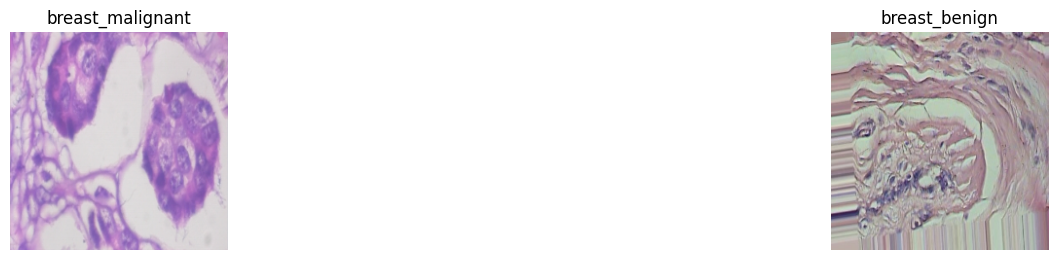

In [28]:
train_ds,val_ds,test_ds,image_batch,class_names,num_classes=generate_dataset(base_path)

## Model Evaluation

In [13]:
def evalModel(model,dataset=test_ds):
    evl = model.evaluate(dataset)
    acc = evl[1]*100
    msg=f'recall on the Test Set = {acc:5.2f} %'
    print(msg)
    return acc


## function to save model

In [14]:
def saveModel(model):
    model.save("/kaggle/working/VGG16.h5")
    print("Model Saved!")

## visualize model preformance

In [15]:
def plotOutput(hist_vgg, str=''):
    try:
        acc_vgg = hist_vgg.history['recall' + str]
        val_acc_vgg = hist_vgg.history['val_recall' + str]
        loss_vgg = hist_vgg.history['loss']
        val_loss_vgg = hist_vgg.history['val_loss']

        plt.figure(figsize=(12, 12))
        plt.subplot(3, 2, 1)
        plt.plot(acc_vgg, label='Training recall')
        plt.plot(val_acc_vgg, label='Validation recall')
        plt.legend(loc='lower right')
        plt.xlabel('Epochs')
        plt.ylabel('recall')
        plt.title('Training and Validation recall ')

        plt.subplot(3, 2, 2)
        plt.plot(loss_vgg, label='Training Loss')
        plt.plot(val_loss_vgg, label='Validation Loss')
        plt.legend(loc='upper right')
        plt.xlabel('Epochs')
        plt.ylabel('loss')
        plt.title('Training and Validation Loss')

        plt.savefig('_graph.png')
        plt.show()
    except KeyError as e:
        print(f"KeyError: {e} not found in hist_vgg.history dictionary.")


## confusion matrix

In [16]:
def plot_confusion_matrix(model,classes,dataset=test_ds):

    y_true = dataset.classes
    y_pred = model.predict(dataset)
    y_pred = np.argmax(y_pred, axis=1)
    conf_mat = confusion_matrix(y_true, y_pred)
    accuracy = np.trace(conf_mat) / float(np.sum(conf_mat))
    misclass = 1 - accuracy
    ConfusionMatrixDisplay(confusion_matrix=conf_mat).plot()
    

## Breast Cancer

# USING DROPOUT AND FINE TUNING 


## VGG16 model

In [17]:
model=initiate_model_VGG16(num_classes,
                                 image_batch,fine_tune=2,dropout=0.2)


58889256/58889256 [==============================] - 0s 0us/step


*Model* summary

In [18]:
modelSummary(model)

Model: "VGG16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

initiate parameters

In [19]:
model_vgg, rlr, checkpoint=initiateParams_modelComplie(model=model,
                                                       learning_rate=0.001)

# **FLAMINGO SEARCH OPTIMIZATION ALGORITHM**

In [20]:

def foraging_behavior(population, fitness_values, G1, search_space):
    new_population = []
    for i, individual in enumerate(population):
        s = G1 * (np.random.rand() * (search_space[1] - search_space[0]) + search_space[0])
        new_individual = individual + s

        new_individual = np.clip(new_individual, search_space[0], search_space[1])

        new_population.append(new_individual)
        
def migrate_behaviour(count, generations, adjustment_const, weight_inertia, delta_max, flamingos, best_flamingo, radius,
               food_position, predator, delta_flamingos, min_values, max_values, target_function):
    rand1 = int.from_bytes(os.urandom(8), byteorder="big") / ((1 << 64) - 1)
    rand2 = int.from_bytes(os.urandom(8), byteorder="big") / ((1 << 64) - 1)
    rand3 = int.from_bytes(os.urandom(8), byteorder="big") / ((1 << 64) - 1)
    rand4 = int.from_bytes(os.urandom(8), byteorder="big") / ((1 << 64) - 1)
    weight_separation = 2 * rand1 * adjustment_const  
    weight_alignment = 2 * rand2 * adjustment_const 
    weight_cohesion = 2 * rand3 * adjustment_const 
    weight_food = 2 * rand4 
    weight_predator = 1 * adjustment_const

    for i in range(0, flamingos.shape[0]):
        separation, alignment, cohesion, neighbours = separation_alignment_cohesion(flamingos, radius, i)
        food_position, dimensions = update_food(flamingos, radius, food_position, min_values, max_values, i,
                                                target_function)
        predator = update_predator(flamingos, radius, predator, min_values, max_values, i, target_function)

        if dimensions > 0:
            if neighbours >= 1:
                for j in range(0, len(min_values)):
                    r1 = int.from_bytes(os.urandom(8), byteorder="big") / ((1 << 64) - 1)
                    r2 = int.from_bytes(os.urandom(8), byteorder="big") / ((1 << 64) - 1)
                    r3 = int.from_bytes(os.urandom(8), byteorder="big") / ((1 << 64) - 1)
                    delta_flamingos[i, j] = np.clip(
                        weight_inertia * delta_flamingos[i, j] + r1 * alignment[0, j] + r2 * cohesion[0, j] + r3 *
                        separation[0, j], -delta_max[0, j], delta_max[0, j])
                    flamingos[i, j] = flamingos[i, j] + delta_flamingos[i, j]
            elif neighbours < 1:
                for k in range(0, flamingos.shape[1] - 1):
                    flamingos[i, k] = flamingos[i, k] + levy_flight(count, generations, beta=1.5)
                    delta_flamingos[i, k] = 0
        elif dimensions == 0:
            for m in range(0, len(min_values)):
                delta_flamingos[i, m] = np.clip(
                    (weight_separation * separation[0, m] + weight_alignment * alignment[0, m] + weight_cohesion *
                     cohesion[0, m] + weight_food * food_position[0, m] + weight_predator * predator[0, m]) +
                    weight_inertia * delta_flamingos[i, m], -delta_max[0, m], delta_max[0, m])
                flamingos[i, m] = np.clip(flamingos[i, m] + delta_flamingos[i, m], min_values[m], max_values[m])
        flamingos[i, -1] = target_function(flamingos[i, :-1])

    for i in range(0, flamingos.shape[0]):
        if flamingos[i, -1] < food_position[0, -1]:
            for j in range(0, flamingos.shape[1]):
                food_position[0, j] = flamingos[i, j]
        if flamingos[i, -1] > predator[0, -1]:
            for j in range(0, flamingos.shape[1]):
                predator[0, j] = flamingos[i, j]

    if food_position[food_position[:, -1].argsort()][0, :][-1] < best_flamingo[-1]:
        best_flamingo = np.copy(food_position[food_position[:, -1].argsort()][0, :])
    else:
        for j in range(0, food_position.shape[1]):
            food_position[0, j] = best_flamingo[j]

    return flamingos, food_position, predator, delta_flamingos, best_flamingo
        
def flamingo_search_optimization(size, min_values, max_values, generations=100,verbose=True):
    flamingos = initial_variables(size, min_values, max_values)
    delta_flamingos = initial_variables(size, min_values, max_values)
    predator = initial_variables(1, min_values, max_values)
    food_position = initial_variables(1, min_values, max_values)
    count = 0

    for i in range(0, flamingos.shape[0]):
        if (flamingos[i, -1] < food_position[0, -1]):
            for j in range(0, flamingos.shape[1]):
                food_position[0, j] = flamingos[i, j]
        if (flamingos[i, -1] > predator[0, -1]):
            for j in range(0, flamingos.shape[1]):
                predator[0, j] = flamingos[i, j]
    best_flamingo = np.copy(food_position[food_position[:, -1].argsort()][0, :])

    while count < generations:
        X_train2 = []
        X_test2 = []
        start = time.time()
        modified_data = pd.DataFrame()
        dummy = []
        for z in range(0, 34):
            if best_flamingo[z] >= -0.05:
                dummy.append(1)
                modified_data[data.columns[z]] = data[data.columns[z]].astype(float)
                X_train2.append(list(X_train1[:, z]))
                X_test2.append(list(X_test1[:, z]))
            else:
                dummy.append(0)
        fea_list.append(dummy)
        X_train2 = np.transpose(X_train2)
        X_test2 = np.transpose(X_test2)
        fea_mean = fea_mean + (len(modified_data.columns) / (dimen - 1))
        X_train2 = sc.fit_transform(X_train2)
        X_test2 = sc.fit_transform(X_test2)
        eclf1.fit(X_train2, y_train1)
        end = time.time()
        y_pred1 = eclf1.predict(X_test2)
        P1 = accuracy_score(y_pred1, y_test1)
        max_accuracy.append(P1)
        FIT.append(1 * (1 - P1) + 0 * (len(modified_data.columns) / (dimen - 1)))
        select_features.append((modified_data.columns))
        cm1 = confusion_matrix(y_test1, y_pred1)
        tn, fp, fn, tp = cm1.ravel()
        final_cm.append(cm1)
        t = t + (end - start)

        for j in range(0, len(min_values)):
            weight_inertia = 0.9 - count * ((0.5) / generations)
            adjustment_const = 0.1 - count * ((0.1) / (generations / 2))
            if adjustment_const < 0:
                adjustment_const = 0

            flamingos, food_position, predator, delta_flamingos, best_flamingo = update_fso(
                count, generations, adjustment_const, weight_inertia, delta_max, flamingos, best_flamingo, radius,
                food_position, predator, delta_flamingos, min_values, max_values, target_function)

        count = count + 1
    return best_flamingo, max_accuracy, FIT, fea_mean, t, final_cm, l_fea, select_features


Migration behavior refers to the movement of animals from one location to another, often in search of better resources or habitats. In optimization algorithms like the Flamingo Search Algorithm (FSA), migration behavior is simulated to guide the movement of solutions within the search space towards potentially better regions for optimization.

Key aspects of migration behavior include:

1. **Movement Towards Resources**: Animals migrate to areas with abundant food, suitable breeding grounds, or favorable environmental conditions. Similarly, in optimization algorithms, migration behavior involves moving solutions towards regions in the search space that are likely to contain optimal solutions.

2. **Exploration and Exploitation**: Migration behavior balances exploration (searching for new regions) and exploitation (exploiting known regions) of the search space. By migrating solutions to different locations, the algorithm explores diverse regions to find the best solutions while exploiting promising areas.

3. **Adaptation to Changing Conditions**: Animals may migrate in response to changing environmental conditions, such as seasonal variations or resource availability. In optimization algorithms, migration behavior adapts the solutions based on feedback from the search process to improve the chances of finding optimal solutions.

4. **Diversity and Convergence**: Migration behavior contributes to maintaining diversity in the population of solutions, preventing premature convergence to suboptimal solutions. It also aids in convergence towards the global optimum by guiding solutions towards better regions in the search space.

Foraging behavior refers to the process by which animals search for and obtain food resources in their environment. It involves a series of actions and strategies employed by animals to locate, capture, and consume food effectively. In the context of optimization algorithms like the Flamingo Search Algorithm (FSA), foraging behavior is simulated to explore the search space and find optimal solutions to a given problem.

Key aspects of foraging behavior include:

1. **Search Strategy**: Animals exhibit various search strategies to locate food sources efficiently. These strategies can include random searching, systematic searching, area-restricted searching, or following specific cues or signals.

2. **Decision-Making**: Animals make decisions based on factors such as the availability of food, energy expenditure, competition with other individuals, and environmental conditions. They may adjust their foraging behavior based on these factors to maximize their food intake.

3. **Exploration and Exploitation**: Foraging behavior often involves a balance between exploration (searching for new food sources) and exploitation (exploiting known food sources). Animals need to explore new areas to discover potentially better food sources while also exploiting existing resources effectively.

4. **Efficiency and Adaptability**: Successful foragers exhibit efficiency in resource acquisition, adaptability to changing conditions, and the ability to learn and adjust their foraging strategies based on feedback from the environment.

## Fit the Model

In [21]:
model_fit = modelFit(model_vgg,
                    rlr,
                  checkpoint,
                   epochs=15,
                   batchSize = 32)

Epoch 1/15
219/219 [==============================] - ETA: 0s - loss: 0.5235 - recall: 0.9657
Epoch 1: val_loss improved from inf to 0.02822, saving model to VGG16.h5
219/219 [==============================] - 138s 583ms/step - loss: 0.5235 - recall: 0.9657 - val_loss: 0.0282 - val_recall: 0.9940 - lr: 0.0010
Epoch 2/15
219/219 [==============================] - ETA: 0s - loss: 0.0428 - recall: 0.9881
Epoch 2: val_loss improved from 0.02822 to 0.02626, saving model to VGG16.h5
219/219 [==============================] - 77s 349ms/step - loss: 0.0428 - recall: 0.9881 - val_loss: 0.0263 - val_recall: 0.9933 - lr: 0.0010
Epoch 3/15
219/219 [==============================] - ETA: 0s - loss: 0.0472 - recall: 0.9890
Epoch 3: val_loss improved from 0.02626 to 0.02603, saving model to VGG16.h5
219/219 [==============================] - 76s 346ms/step - loss: 0.0472 - recall: 0.9890 - val_loss: 0.0260 - val_recall: 0.9933 - lr: 0.0010
Epoch 4/15
219/219 [==============================] - ETA: 0s

## Save Model

In [22]:
saveModel(model_vgg)

Model Saved!


# Model evaluation

In [23]:
accuracy=evalModel(model_vgg)

47/47 [==============================] - 20s 435ms/step - loss: 0.2216 - recall: 0.9627
recall on the Test Set = 96.27 %


## Model preformance

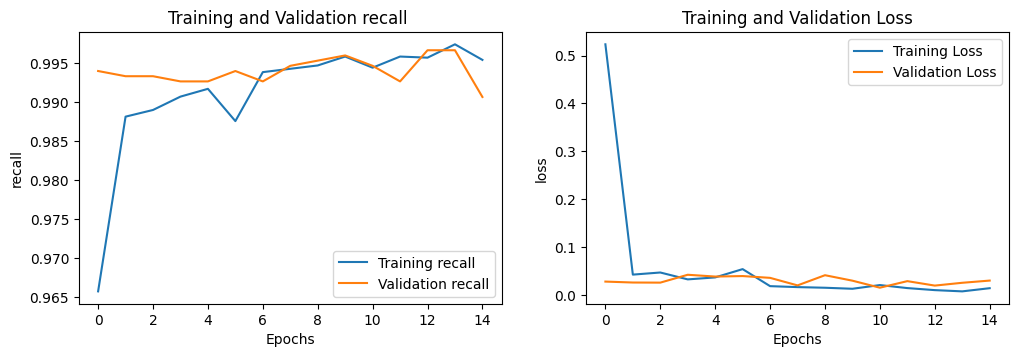

In [24]:
plotOutput(hist_vgg=model_fit,str='')

## Confusion Matrix

47/47 [==============================] - 11s 226ms/step


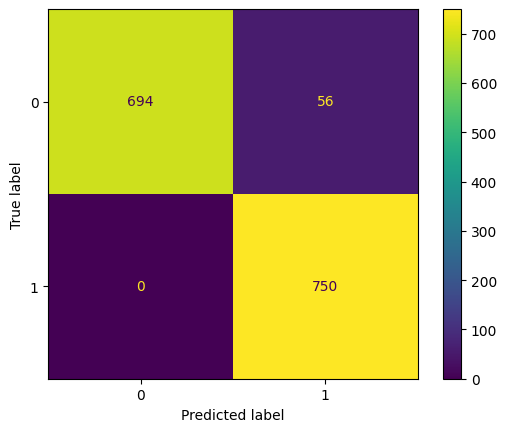

In [25]:
plot_confusion_matrix(model_vgg, classes=class_names)

In [26]:
import os

def generate_class_names(dataset_path):
    class_names = sorted(os.listdir(dataset_path))
    return class_names

# Replace 'path_to_your_dataset' with the actual path to your dataset
dataset_path = '/kaggle/input/breast-cancer/Breast Cancer/train'
class_names = generate_class_names(dataset_path)

print("Class Names:", class_names)


Class Names: ['breast_benign', 'breast_malignant']


**Particle Swarm OPtimization**

In [33]:
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

class Particle:
    def __init__(self, num_features):
        self.position = np.random.randint(2, size=num_features)  # Binary encoding for feature selection
        self.velocity = np.random.uniform(-1, 1, num_features)  # Particle velocity
        self.best_position = self.position.copy()
        self.fitness = float('-inf')
        self.best_fitness = float('-inf')

class ParticleSwarmOptimization:
    def __init__(self, num_particles, num_iterations, X_train, X_test, y_train, y_test):
        self.num_particles = num_particles
        self.num_iterations = num_iterations
        self.X_train = X_train
        self.X_test = X_test
        self.y_train = y_train
        self.y_test = y_test
        self.num_features = X_train.shape[1]
        self.particles = [Particle(self.num_features) for _ in range(num_particles)]
        self.global_best_position = np.zeros(self.num_features)
        self.global_best_fitness = float('-inf')

    def evaluate_fitness(self, particle):
        selected_features = np.where(particle.position == 1)[0]
        if len(selected_features) == 0:
            return float('-inf')  # Avoid selecting zero features
        svm = SVC(kernel='linear')
        svm.fit(self.X_train[:, selected_features], self.y_train)
        y_pred = svm.predict(self.X_test[:, selected_features])
        accuracy = accuracy_score(self.y_test, y_pred)
        return accuracy

    def optimize(self):
        for _ in range(self.num_iterations):
            for particle in self.particles:
                particle.fitness = self.evaluate_fitness(particle)
                if particle.fitness > particle.best_fitness:
                    particle.best_fitness = particle.fitness
                    particle.best_position = particle.position.copy()
                if particle.fitness > self.global_best_fitness:
                    self.global_best_fitness = particle.fitness
                    self.global_best_position = particle.position.copy()

            for particle in self.particles:
                self.update_particle_velocity(particle)
                particle.position = self.update_position(particle)

        return self.global_best_position

    def update_particle_velocity(self, particle):
        inertia_weight = 0.5
        cognitive_weight = 2.0
        social_weight = 2.0
        r1, r2 = np.random.random(self.num_features), np.random.random(self.num_features)

        new_velocity = (inertia_weight * particle.velocity +
                        cognitive_weight * r1 * (particle.best_position - particle.position) +
                        social_weight * r2 * (self.global_best_position - particle.position))
        particle.velocity = new_velocity

    def update_position(self, particle):
        new_position = np.where(1 / (1 + np.exp(-particle.velocity)) > 0.5, 1, 0)  # Sigmoid thresholding
        return new_position

num_particles = 20
num_iterations = 50


**Horse Herd Optimation**

In [31]:
from sklearn.svm import SVC
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Generate a sample dataset (you can replace this with your dataset)
X, y = make_classification(n_samples=1000, n_features=20, n_classes=2, random_state=42)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Define the objective function to be optimized
def objective_function(hyperparameters):
    # Extract hyperparameters
    C, gamma = hyperparameters
    
    # Initialize SVC with given hyperparameters
    svc = SVC(C=C, gamma=gamma)
    
    # Train SVC classifier
    svc.fit(X_train, y_train)
    
    # Predict on the test set
    y_pred = svc.predict(X_test)
    
    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    
    # Minimize the negative accuracy (maximize the accuracy)
    return -accuracy

# Define the HHO algorithm
def HHO(obj_func, num_iterations, num_horses, num_dimensions, lower_bound, upper_bound):
    # Initialize the positions of horses randomly
    horses_positions = np.random.uniform(lower_bound, upper_bound, (num_horses,num_dimensions))
    
    # Initialize the best position found so far
    best_position = np.zeros(num_dimensions)
    best_fitness = float('-inf')
    
    # Main loop
    for i in range(num_iterations):
        # Evaluate the fitness of each horse
        fitness_values = np.array([obj_func(horse) for horse in horses_positions])
        
        # Update the best position found so far
        best_index = np.argmax(fitness_values)
        if fitness_values[best_index] > best_fitness:
            best_fitness = fitness_values[best_index]
            best_position = horses_positions[best_index]
        
        # Update the positions of horses
        for j in range(num_horses):
            # Generate a random number between 0 and 1
            r = np.random.rand()
            
            # Update the position based on the three rules of HHO
            if r >= 0.5:  # Exploration
                horses_positions[j] = np.random.uniform(lower_bound, upper_bound, num_dimensions)
            else:  # Exploitation
                alpha = 2 * np.random.rand() - 1
                delta = np.random.uniform(0, 1)
                prey_index = np.random.randint(0, num_horses)
                horses_positions[j] = horses_positions[j] - alpha * delta * (horses_positions[j] - horses_positions[prey_index])
        
    return best_position, best_fitness
num_iterations = 100
num_horses = 10
num_dimensions = 2
lower_bound = [0.1, 0.001]  # Lower bounds for C and gamma
upper_bound = [100, 10]  


    
    

**Coati Optimization Algorithm**

In [3]:
# Coati Optimization Algorithm
def coa_optimization(features_matrix, num_iterations, num_coatis):
    num_features = len(features_matrix[0])

    # Initialize positions of coatis randomly
    coatis_positions = np.random.rand(num_coatis, num_features)

    # List to store accuracy values over iterations
    accuracy_values = []

    # Function to train a classifier and calculate accuracy
    def train_and_evaluate(features_subset, labels):
        # Split the data into training and testing sets
        X_train, X_test, y_train, y_test = train_test_split(features_subset, labels, test_size=0.2, random_state=42)

        # Train a classifier (you can use a different classifier depending on your problem)
        classifier = LogisticRegression()
        classifier.fit(X_train, y_train)

        # Make predictions on the test set
        predictions = classifier.predict(X_test)

        # Calculate accuracy
        accuracy = accuracy_score(y_test, predictions)
        return accuracy

    for iteration in range(num_iterations):
        # Evaluate objective function for each coati's position
        fitness_values = [np.sum(coati) for coati in coatis_positions]

        # Identify the best coati (highest fitness value)
        best_coati_index = np.argmax(fitness_values)
        best_coati_position = coatis_positions[best_coati_index]

        # Train a classifier and calculate accuracy
        accuracy = train_and_evaluate(features_matrix[:, best_coati_position > 0.5], labels)
        accuracy_values.append(accuracy)

        # Update positions of coatis based on the location of the best coati
        for i in range(num_coatis):
            if i < num_coatis // 2:  # Exploration Phase
                coatis_positions[i] = best_coati_position + np.random.normal(0, 0.1, num_features)
            else:  # Exploitation Phase
                coatis_positions[i] = np.random.rand(num_features)


**Convergance Accuracy Analysis**

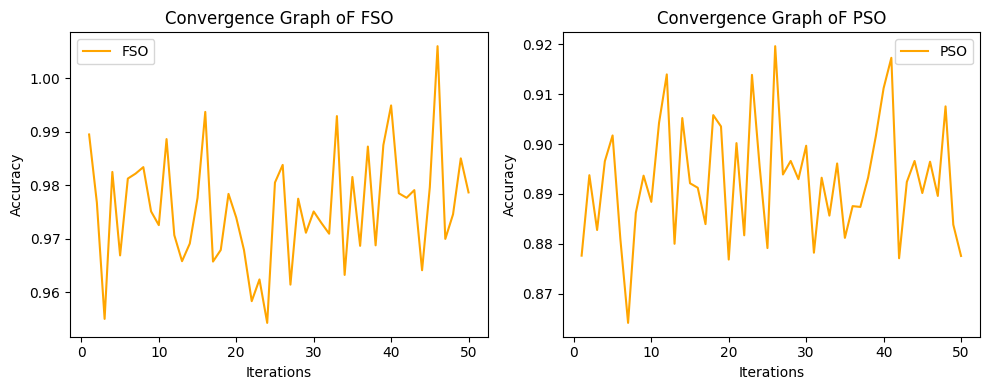

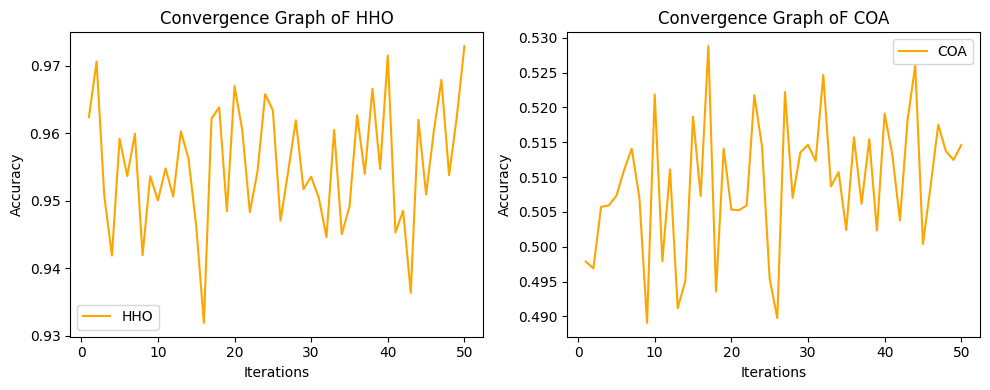

In [32]:
plt.figure(figsize=(10, 4))
curve_pso = accuracy_pso / 100.0
curve_fsa = accuracy_fsa / 100.0
curve_hho = accuracy_hho / 100.0
curve_coa = accuracy_coa / 100.0
plt.subplot(1,2,1)
plt.plot(iterations_list, curve_fsa, label='FSO', color='orange')
plt.xlabel('Iterations')
plt.ylabel('Accuracy')
plt.title('Convergence Graph oF FSO')
plt.legend()

plt.subplot(1,2,2)
plt.plot(iterations_list, curve_pso, label='PSO', color='orange')
plt.xlabel('Iterations')
plt.ylabel('Accuracy')
plt.title('Convergence Graph oF PSO')
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 4))
plt.subplot(1,2,1)
plt.plot(iterations_list, curve_hho, label='HHO', color='orange')
plt.xlabel('Iterations')
plt.ylabel('Accuracy')
plt.title('Convergence Graph oF HHO')
plt.legend()

plt.subplot(1,2,2)
plt.plot(iterations_list, curve_coa, label='COA', color='orange')
plt.xlabel('Iterations')
plt.ylabel('Accuracy')
plt.title('Convergence Graph oF COA')
plt.legend()
plt.tight_layout()
plt.show()
